# Basics of Scientific Computing

## General Strategy

## Approximations in Scientific Computing

### Absolute and Relative Error Calculation

The **relative error** measures the accuracy of an approximation compared to the actual value. It is calculated as a percentage:

$$
\text{Relative Error (\%)} = \frac{|\text{Approximate Value} - \text{True Value}|}{|\text{True Value}|} \times 100
$$

The following Python script demonstrates a function for relative error calculation.

In [74]:
def relative_error(apprx,exact):
    """Compute relative error."""
    return abs(apprx-exact)/abs(exact)

### Sensitivity and Conditioning

The **condition number** of a function $f$ at a point $x$ quantifies how sensitive the output of $f(x)$ is to small changes in the input $x$. It measures the potential for error amplification in numerical computations. For a function $f(x)$, the condition number $\kappa(x)$ is defined as:

$$
\kappa(x) = \left| \frac{x f'(x)}{f(x)} \right|
$$

where:
- $ f(x) $ is the function,
- $ f'(x) $ is the derivative of $ f(x) $,
- $ x $ is the input value.

If $ \kappa(x) $ is **large**, the problem is **ill-conditioned** (small input changes cause large output variations).  
If $ \kappa(x) $ is **small**, the problem is **well-conditioned** (output changes proportionally with input).

In [75]:
def condition_number(f, x, h=1e-5):
    """Computes the condition number of a function f at x."""
    # Compute numerical derivative using central difference method
    df_dx = (f(x + h) - f(x - h)) / (2 * h)
    
    # Avoid division by zero
    if f(x) == 0:
        raise ValueError("Condition number is undefined at x where f(x) = 0.")
    
    # Compute the condition number
    kappa = abs((x * df_dx) / f(x))
    
    return kappa

Example Usage:

In [78]:
f = lambda x: x**2  # Example function: f(x) = x^2
x_val = 2.0  # Evaluate at x = 2

cond_num = condition_number(f, x_val)
print(f"Condition number of f(x) = x^2 at x = {x_val} is {cond_num:.4f}")

Condition number of f(x) = x^2 at x = 2.0 is 2.0000


The **condition cumber** for a matrix $A$, the condition number in terms of the **norm** is:

$$
\kappa(A) = \|A\| \cdot \|A^{-1}\|
$$

where $ \|A\| $ is the matrix norm. A high $ \kappa(A) $ means solving $ Ax = b $ is sensitive to numerical errors.

- $ \kappa \approx 1 $ → **Well-conditioned problem** (stable computation).
- $ \kappa \gg 1 $ → **Ill-conditioned problem** (small changes in input cause large output errors).
- $ \kappa \to \infty $ → **Singular or nearly singular problem** (numerical instability).

The condition number provides a critical measure of problem stability. Understanding it helps avoid numerical inaccuracies in computation.

## Computer Arithmetic

### Machine Epsilon

In [5]:
def machine_epsilon(float_type):
    """Returns the number of significant digits in the mantissa
    for a binary floats.
    """

    Eps = float_type(1)
    One = float_type(1)
    Two = float_type(2)

    while True:
        
        if Eps/Two+One<=One:
            break
        
        Eps = Eps/Two

    t = (One-np.log(Eps)/np.log(Two))

    return int(t)

In [6]:
print(machine_epsilon(float))
print(machine_epsilon(np.float32))
print(machine_epsilon(np.float64))

53
24
53


### Floating Point Arithmetic

The objective of this exercise is to investigate the effect of round-off error on large numbers of interdependent computations.

1. Initialize sums with different precisions:

In [67]:
sum1 = np.float32(0)  # Single precision
sum2 = np.float64(0)  # Double precision
sum3 = 0.0            # Default Python float (double precision)

2. Define small increments

In [68]:
x1 = np.float32(1e-5)
x2 = np.float64(1e-5)
x3 = 1e-5  # Default float (double precision)

3. Perform summation

In [69]:
# Number of iterations
N = 100_000

for _ in range(N):
    sum1 += x1
    sum2 += x2
    sum3 += x3

4. Compute relative error in percentage

In [70]:
error1 = relative_error(sum1,1)*100
error2 = relative_error(sum2,1)*100
error3 = relative_error(sum3,1)*100

5. Display results

In [72]:
print(f"Single precision: {sum1:.8f}, Error: {error1:.8f}%")
print(f"Double precision (numpy): {sum2:.8f}, Error: {error2:.8f}%")
print(f"Double precision (default): {sum3:.8f}, Error: {error3:.8f}%")

Single precision: 1.00099015, Error: 0.09901524%
Double precision (numpy): 1.00000000, Error: 0.00000000%
Double precision (default): 1.00000000, Error: 0.00000000%


### Cancellation

Catastrophic cancellation occurs when subtracting nearly equal floating-point numbers, leading to significant loss of precision.

#### Example 1: Summing Alternating Series

The Taylor series expansion of \( e^x \) around \( x = 0 \) is given by:

$$
e^x = \sum_{n=0}^{\infty} \frac{x^n}{n!}
$$

Expanding the first few terms:

$$
e^x = 1 + x + \frac{x^2}{2!} + \frac{x^3}{3!} + \frac{x^4}{4!} + \dots
$$

for large negative x, the terms alternate in sign and decrease rapidly. This can cause catastrophic cancellation due to loss of significant digits in floating-point arithmetic.

The following Python code demonstrates this issue:

In [12]:
from math import factorial

In [13]:
def exponential(x,n_terms=50):
    """Compute exp(x) using the Taylor series expansion."""
    sum_exp = 0.0
    
    for n in range(n_terms):
        sum_exp += (x**n)/factorial(n)
        
    return sum_exp

In [15]:
x_values = np.linspace(-20,0,100)

In [16]:
exact_values = np.exp(x_values)
apprx_values = exponential(x_values)

In [17]:
errors = relative_error(apprx_values,exact_values)
#np.array([relative_error(approx, exact) for approx, exact in zip(approx_values, exact_values)])

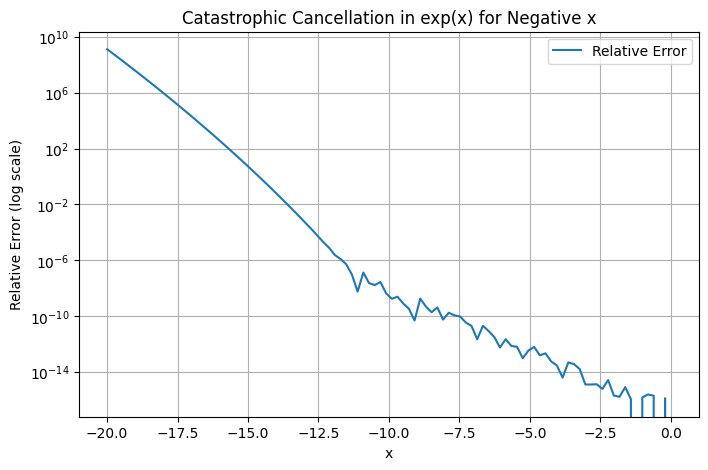

In [20]:
plt.figure(figsize=(8, 5))
plt.semilogy(x_values, errors, label="Relative Error")
plt.xlabel("x")
plt.ylabel("Relative Error (log scale)")
plt.title("Catastrophic Cancellation in exp(x) for Negative x")
plt.legend()
plt.grid()
plt.show()

This code compares the Taylor series approximation of $e^x$ with the actual np.exp(x) value for negative $x$,
showing how relative error increases due to catastrophic cancellation. The semilogarithmic plot highlights the growing error as x becomes more negative.

#### Example 2: Quadratic Formula

I've added a demonstration of catastrophic cancellation when finding the roots of a quadratic equation. The code now includes both a naive and a numerically stable approach to computing the roots.

In [32]:
from math import sqrt

In [25]:
def quadratic_equation(x,a=1,b=1,c=1):
    """Returns the value of quadratic equation."""    
    return a*x**2+b*x+c

In [34]:
def naive_solver(a,b,c):
    """Return the root values of x for quadratic equation,
    naive implementation."""
    D = sqrt(b**2-4*a*c)

    x1 = (-b+D)/(2*a)
    x2 = (-b-D)/(2*a)
    
    return x1, x2

In [48]:
def stable_solver(a,b,c):
    """Return the root values of x for quadratic equation,
    wise implementation."""
    D = sqrt(b**2-4*a*c)

    if b>=0:
        x1 = (2*c)/(-b-D)
        x2 = (-b-D)/(2*a)
    elif np.sign(b*D)<0:
        x1 = (-b+D)/(2*a)
        x2 = (2*c)/(-b+D)

    return x1, x2

In [49]:
a,b,c = 1., 200., -1.5e-14

In [50]:
x1,x2 = naive_solver(a,b,c)
y1 = quadratic_equation(x1,a,b,c)
y2 = quadratic_equation(x2,a,b,c)
print(f"{x1 = }, {y1 = }")
print(f"{x2 = }, {y2 = }")

x1 = 0.0, y1 = -1.5e-14
x2 = -200.0, y2 = -1.5e-14


In [51]:
x1,x2 = stable_solver(a,b,c)
y1 = quadratic_equation(x1,a,b,c)
y2 = quadratic_equation(x2,a,b,c)
print(f"{x1 = }, {y1 = }")
print(f"{x2 = }, {y2 = }")

x1 = 7.5e-17, y1 = 0.0
x2 = -200.0, y2 = -1.5e-14


## Mathematical Software